### Multi-resolution image registration by homography transformation using matrix manifold optimization

In [1]:
from skimage import io
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
from skimage.transform import pyramid_gaussian
from skimage.filters import gaussian
from skimage.filters import threshold_otsu
from torch.autograd import Function

from google.colab import drive
drive.mount('/content/drive')
#!ls "/content/drive/My Drive"

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

ModuleNotFoundError: No module named 'google'

Text(0.5, 1.0, 'Moving Image')

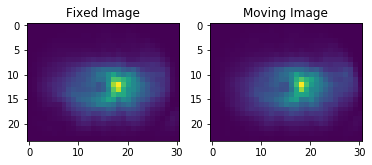

In [7]:
I = io.imread("/content/drive/My Drive/CMPUT617_2019/Assignment_2/fixed.bmp").astype(np.float32) # fixed image
J = io.imread("/content/drive/My Drive/CMPUT617_2019/Assignment_2/moving.bmp").astype(np.float32) # fixed image

pyramid_I = tuple(pyramid_gaussian(I, downscale=2, multichannel=False))
pyramid_J = tuple(pyramid_gaussian(J, downscale=2, multichannel=False))

%matplotlib inline
fig=plt.figure()
fig.add_subplot(1,2,1)
plt.imshow(pyramid_I[7])
plt.title("Fixed Image")
fig.add_subplot(1,2,2)
plt.imshow(pyramid_J[7])         
plt.title("Moving Image")

In [0]:
def PerspectiveTransform(I, H, xv, yv):
  
  # apply homography
  xvt = (xv*H[0,0]+yv*H[0,1]+H[0,2])/(xv*H[2,0]+yv*H[2,1]+H[2,2])
  yvt = (xv*H[1,0]+yv*H[1,1]+H[1,2])/(xv*H[2,0]+yv*H[2,1]+H[2,2])
  J = F.grid_sample(I.view(1,1,height,width),torch.stack([xvt,yvt],2).unsqueeze(0)).squeeze()
  return J

def MatrixExp(B, u):
        
  C = torch.sum(B*u,0)
  A = torch.eye(3).to(device)
  H = A + C
  for i in torch.arange(2,10):
    A = torch.mm(A/i,C)
    H = H + A
  return H

In [9]:
# perspective transform basis matrices

B = torch.zeros(8,3,3).to(device)
B[0,0,2] = 1.0
B[1,1,2] = 1.0
B[2,0,1] = 1.0
B[3,1,0] = 1.0
B[4,0,0], B[4,1,1] = 1.0, -1.0
B[5,1,1], B[5,2,2] = -1.0, 1.0
B[6,2,0] = 1.0
B[7,2,1] = 1.0

# multi-resolution registration
# Consider 8 levels in the pyramid for this example
learning_rate = 1e-5
nItr = torch.tensor([300,300,300,300,400,500,600,600])

torch.autograd.set_detect_anomaly(True)

# create variables and optimization at each level
v = Variable(torch.zeros(8,1,1).to(device), requires_grad=True)
optimizer = optim.Adam([v], lr=learning_rate, amsgrad=True)

for level in torch.arange(7,-1,-1): # start at level 7
  if level>0:
    I = torch.tensor(pyramid_I[level].astype(np.float32)).to(device)
    J = torch.tensor(pyramid_J[level].astype(np.float32)).to(device)
  else:    
    I = torch.tensor(gaussian(pyramid_I[level].astype(np.float32),2.0)).to(device)
    J = torch.tensor(gaussian(pyramid_J[level].astype(np.float32),2.0)).to(device)
  
  height,width = I.shape

  # choose a set of pixel locations on the template image that are most informative
  tval = 0.9*threshold_otsu(I.cpu().numpy()) # reduce Otsu threshold value a bit to cover slightly wider areas
  important_ind = torch.nonzero((I.data>tval).view([height*width])).squeeze()

  # generate grid only once at each level
  yv, xv = torch.meshgrid([torch.arange(0,height).float().to(device), torch.arange(0,width).float().to(device)])
  # map coordinates to [-1,1]x[-1,1] so that grid_sample works properly
  yv = 2.0*yv/(height-1) - 1.0
  xv = 2.0*xv/(width-1) - 1.0

  for itr in range(nItr[level]):
    J_w = PerspectiveTransform(J, MatrixExp(B,v), xv, yv)
    loss = F.mse_loss(J_w.view([height*width])[important_ind], I.view([height*width])[important_ind])
    #loss = F.mse_loss(J_w, I)
    optimizer.zero_grad()
    loss.backward()
    if itr%100==0:
      loss = F.mse_loss(J_w, I)
      print("Pyramid level:",level.item(),"Iteration:",itr,"MSE loss:",loss.item())
    optimizer.step()

  H = MatrixExp(B,v).detach()
  J_w = PerspectiveTransform(J, H, xv, yv)
  loss = F.mse_loss(J_w, I)
  print("Pyramid level:",level.item(),"Iteration:",itr+1,"MSE loss:",loss.item())

# final transformation
I = torch.tensor(pyramid_I[0].astype(np.float32)).to(device) # without Gaussian
J = torch.tensor(pyramid_J[0].astype(np.float32)).to(device) # without Gaussian
J_w = PerspectiveTransform(J, H, xv, yv)

D = J - I
D_w = J_w - I
print(" ")
print("MSE before registration:",torch.mean(D**2).cpu().item())
print("MSE after registration:",torch.mean(D_w**2).cpu().item())

Pyramid level: 7 Iteration: 0 MSE loss: 6.785189151763916
Pyramid level: 7 Iteration: 100 MSE loss: 5.90302848815918
Pyramid level: 7 Iteration: 200 MSE loss: 5.191329479217529
Pyramid level: 7 Iteration: 300 MSE loss: 4.626938819885254
Pyramid level: 7 Iteration: 400 MSE loss: 4.186849117279053
Pyramid level: 7 Iteration: 500 MSE loss: 3.849334955215454
Pyramid level: 7 Iteration: 600 MSE loss: 3.5966458320617676
Pyramid level: 6 Iteration: 0 MSE loss: 4.964794635772705
Pyramid level: 6 Iteration: 100 MSE loss: 4.6972575187683105
Pyramid level: 6 Iteration: 200 MSE loss: 4.58193302154541
Pyramid level: 6 Iteration: 300 MSE loss: 4.527346134185791
Pyramid level: 6 Iteration: 400 MSE loss: 4.504912376403809
Pyramid level: 6 Iteration: 500 MSE loss: 4.502868175506592
Pyramid level: 6 Iteration: 600 MSE loss: 4.5135602951049805
Pyramid level: 5 Iteration: 0 MSE loss: 6.460305213928223
Pyramid level: 5 Iteration: 100 MSE loss: 5.955394268035889
Pyramid level: 5 Iteration: 200 MSE loss: 5.8

MI before registration: 0.7072216932289866
MI after registration: 0.9903194750739307
tensor([[ 1.0004,  0.0051,  0.0143],
        [-0.0050,  0.9999, -0.0018],
        [-0.0041,  0.0038,  0.9997]], device='cuda:0')


Text(0.5, 1.0, 'Difference image after registration')

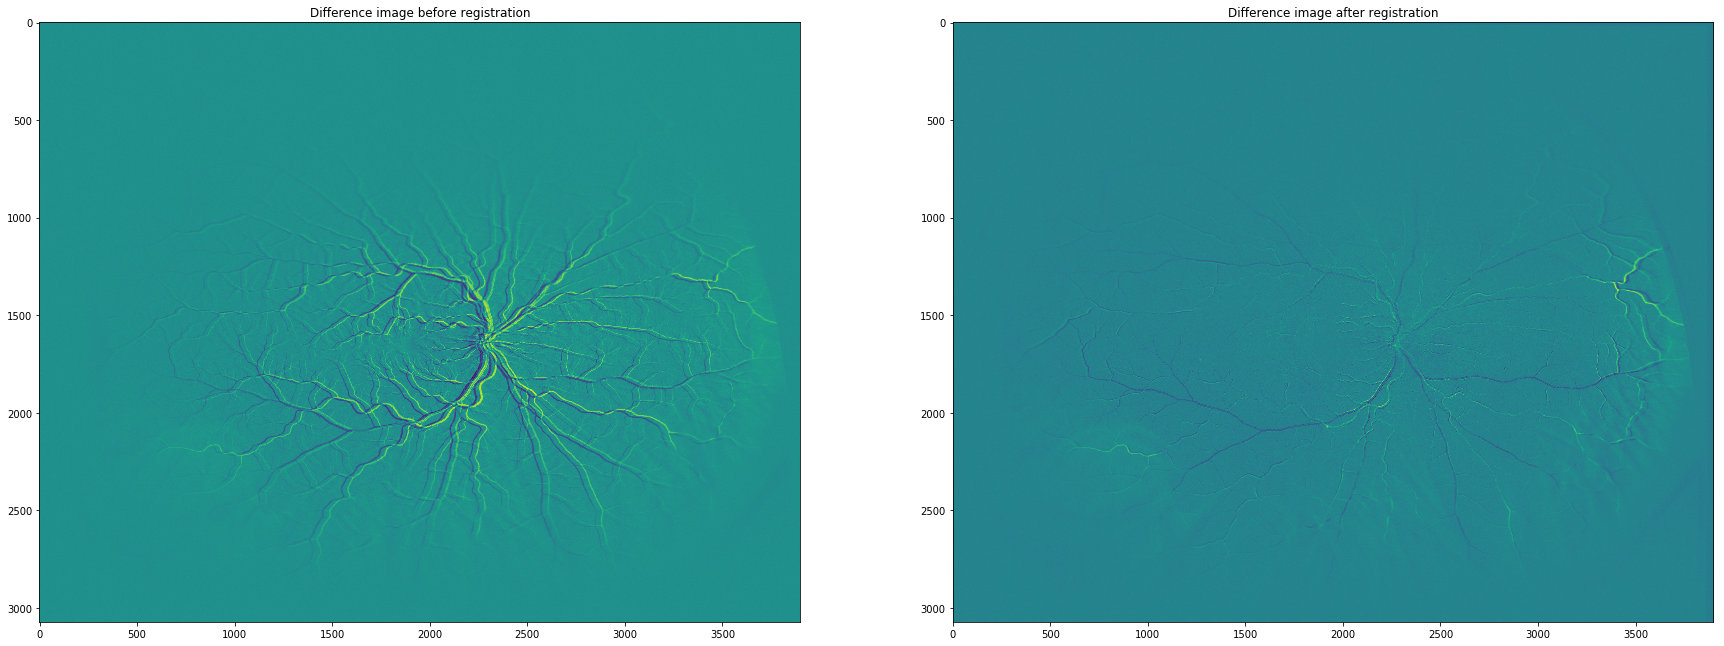

In [5]:
def histogram_mutual_information(image1, image2):
    hgram, x_edges, y_edges = np.histogram2d(image1.ravel(), image2.ravel(), bins=100)
    pxy = hgram / float(np.sum(hgram))
    px = np.sum(pxy, axis=1)
    py = np.sum(pxy, axis=0)
    px_py = px[:, None] * py[None, :]
    nzs = pxy > 0
    return np.sum(pxy[nzs] * np.log(pxy[nzs] / px_py[nzs]))

print("MI before registration:", histogram_mutual_information(pyramid_I[0],pyramid_J[0]))
print("MI after registration:", histogram_mutual_information(pyramid_I[0],J_w.cpu().numpy()))

print(H)
%matplotlib inline
fig=plt.figure(figsize=(30,30))
fig.add_subplot(1,2,1)
plt.imshow(D.cpu().data)
plt.title("Difference image before registration")
fig.add_subplot(1,2,2)
plt.imshow(D_w.cpu().data)         
plt.title("Difference image after registration")